# Previsão com Redes Neurais Recorrentes


In [1]:
import pandas as pd
from pandas import Grouper, DataFrame

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime
import random
import time

from matplotlib import pyplot as plt
import seaborn as sns

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import pickle

import tensorflow as tf

from math import ceil

## Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 15
VAL_SPLIT_SIZE = 15
WINDOW_SIZE = 24
MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

MODEL_PATH = 'MODEL'
SCALER_FILE_NAME = os.path.join(MODEL_PATH, 'scaler.pkl')

BATCH_SIZE = 20


## Funções

In [3]:
# Returns X_train, y_train, X_valid, y_valid, X_test, y_test
def split_train_validation_test_window_dataset(full_dataset: np.ndarray, 
                                               val_percentual_size: int, 
                                               test_percentual_size: int, 
                                               window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    dataset_size: int = full_dataset.shape[0]
    cut_pos_test: int = round(dataset_size - (dataset_size * (test_percentual_size/100)))
    cut_pos_val: int = round(cut_pos_test - (dataset_size * (val_percentual_size/100)))
    
    test_dataset_size: int = dataset_size - cut_pos_test
    val_dataset_size: int = dataset_size - cut_pos_val - test_dataset_size
    
    y_train: np.ndarray = full_dataset[window_size : cut_pos_val]
    y_val: np.ndarray = full_dataset[cut_pos_val : cut_pos_test]
    y_test: np.ndarray = full_dataset[cut_pos_test:]
    
    train_dataset_list = [full_dataset[ind : ind + window_size] for ind in range (cut_pos_val - window_size)]
    X_train = np.array(train_dataset_list)
    
    val_dataset_list = [full_dataset[cut_pos_val + ind - window_size :cut_pos_val + ind] for ind in range (val_dataset_size)]
    X_valid = np.array(val_dataset_list)
    
    test_dataset_list = [full_dataset[cut_pos_test + ind - window_size :cut_pos_test + ind] for ind in range (test_dataset_size)]
    X_test = np.array(test_dataset_list)
    
    return (X_train, y_train, X_valid, y_val, X_test, y_test)

## Carrega Datasets

In [4]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

In [5]:
scaler = MinMaxScaler()
desembolso = desembolso.reshape(-1,1)
scaler.fit(desembolso)
desembolso = scaler.transform(desembolso)
desembolso = desembolso.squeeze()

pickle.dump(scaler, open(SCALER_FILE_NAME, 'wb'))

In [6]:
(X_train, y_train, X_valid, y_valid, X_test, y_test) = split_train_validation_test_window_dataset(desembolso, VAL_SPLIT_SIZE, TEST_SPLIT_SIZE, WINDOW_SIZE)

In [7]:
n_samples = X_train.shape[0] # samples
n_timesteps = X_train.shape[1] # window_size
n_features = 1 #univariate

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
X_valid_rs = X_valid.reshape(X_valid.shape[0], n_timesteps, n_features)

---
### Univariate LSTM

In [93]:
# RNN recebe input_shape no seguinte formato
# (N,T,D), where N is the number of samples, T is length of time sequence and D is the number of features

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, recurrent_dropout=0.1), input_shape=(n_timesteps,n_features)),
    #tf.keras.layers.LSTM(350, input_shape=(n_timesteps,n_features), return_sequences=True),
    tf.keras.layers.SpatialDropout1D(0.1),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,return_sequences=False, recurrent_dropout=0.1)),
    #tf.keras.layers.SpatialDropout1D(0.1),
    #tf.keras.layers.LSTM(350, return_sequences=False),    
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

lstm_model.compile(optimizer='sgd', loss='mse')


In [94]:
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 24, 200)          81600     
 onal)                                                           
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 24, 200)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_21 (Bidirecti  (None, 100)              100400    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 50)                5050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                     

In [95]:
model_univariate_path = os.path.join(MODEL_PATH, 'model-lstm-desembolso-univariate.h5')

history = lstm_model.fit(x=X_train,
                         y=y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=150,
                         shuffle=False,
                         batch_size=BATCH_SIZE,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_univariate_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                        )

Epoch 1/150
4/4 [==============================] - 5s 217ms/step - loss: 0.1039 - val_loss: 0.0028
Epoch 2/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0710 - val_loss: 0.0057
Epoch 3/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0559 - val_loss: 0.0095
Epoch 4/150
4/4 [==============================] - 0s 66ms/step - loss: 0.0536 - val_loss: 0.0116
Epoch 5/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0499 - val_loss: 0.0123
Epoch 6/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0503 - val_loss: 0.0129
Epoch 7/150
4/4 [==============================] - 0s 62ms/step - loss: 0.0520 - val_loss: 0.0128
Epoch 8/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0513 - val_loss: 0.0129
Epoch 9/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0460 - val_loss: 0.0128
Epoch 10/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0508 - val_loss: 0.0121
Epoch 11/150
4/4 [

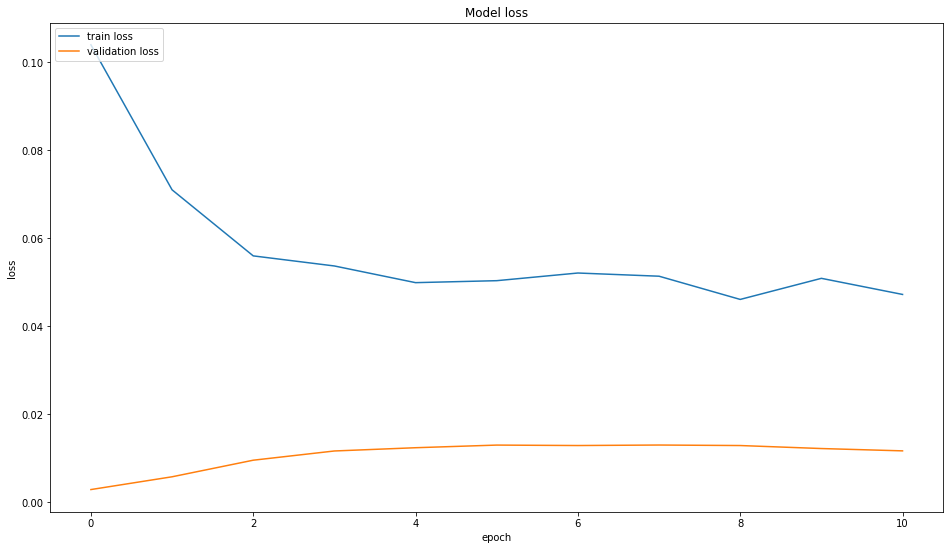

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [97]:
model_univariate = tf.keras.models.load_model(model_univariate_path)

In [98]:
X_test_rs = X_test.reshape(X_test.shape[0], WINDOW_SIZE, 1)

y_predict = model_univariate.predict(X_test_rs)

y_predict = scaler.inverse_transform(y_predict)

y_test_rs = y_test.reshape(-1,1)
y_true = scaler.inverse_transform(y_test_rs)

y_predict_univariate_lstm = y_predict.squeeze()
y_true_univariate_lstm = y_true.squeeze()

In [99]:
print(y_predict_univariate_lstm)

[503.036   503.10696 502.0885  501.03802 498.86874 496.39948 494.68423
 493.6947  492.90237 491.94724 491.45743 490.50702 490.33743 489.93668
 488.52084 487.722   486.89902 486.7907  487.10052 487.40125 487.7333
 487.90384]


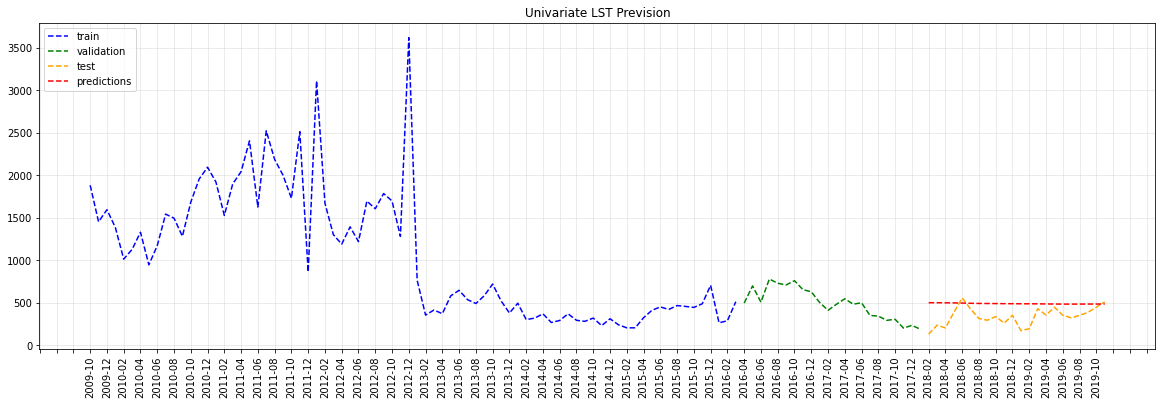

In [100]:
y_train_rs = y_train.reshape(-1,1)
y_train_rs = scaler.inverse_transform(y_train_rs)
y_train_rs = y_train_rs.squeeze()

y_valid_rs = y_valid.reshape(-1,1)
y_valid_rs = scaler.inverse_transform(y_valid_rs)
y_valid_rs = y_valid_rs.squeeze()

len_train = len(y_train_rs)
len_with_valid = len(y_train_rs) + len(y_valid_rs)
len_with_test = len(y_train) + len(y_valid) + len(y_test)

plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len_train], y_train_rs, 'b--', label="train")
plt.plot(desembolso_time[len_train:len_with_valid], y_valid_rs, color='green', linestyle="--", label="validation")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_true_univariate_lstm, color='orange', linestyle='--', label="test")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_predict_univariate_lstm, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Univariate LST Prevision")
plt.grid(alpha=0.3);

In [101]:
univariate_lstm_mse = mean_squared_error(y_true, y_predict_univariate_lstm, squared=True)
univariate_lstm_mae = mean_absolute_error(y_true, y_predict_univariate_lstm)
univariate_lstm_r2 = r2_score(y_true, y_predict_univariate_lstm)
print(f'Mean Squared Error: {univariate_lstm_mse} ')
print(f'Mean Absolute Error: {univariate_lstm_mae}')
print(f'R2 Score: {univariate_lstm_r2}')

Mean Squared Error: 34525.20406477682 
Mean Absolute Error: 158.25630367862215
R2 Score: -2.017096810452107
